In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

In [5]:
# Test on Lunar Lander to check functionality of agent
#env = gym.make('LunarLander-v2')
#n_actions= env.action_space.n

In [2]:
max_steps = 3000000
replay_memory_size = 300000
agent_history_length = 1
evaluate_every = 10000
eval_runs = 20
network_update_every = 100
start_learning = 2000
eps_annealing_steps = 150000

max_episode_length = 250
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#batch_size = 64
#learning_rate = 0.0000000625
batch_size = 32
learning_rate = 0.000001

In [5]:
env = RLTe.RLtractEnvironment(stepWidth=0.81, device = 'cpu')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [21]:
def init_transition():
    state = env.reset()[:2]
    #transition = deque(maxlen=12)
    #while len(transition) < 12:
        #for i in range(len(state.getCoordinate())):
        #    transition.append(state.getCoordinate()[i].item())
    transition = deque(maxlen=8)
    while len(transition) < 8:
        for i in range(len(state)):
            transition.append(state[i])
    return transition

def add_to_transition(state, transition):
    #for i in range(len(state.getCoordinate())):
    #        transition.append(state.getCoordinate()[i].item())
    for i in range(len(state)):
            transition.append(state[i])                   
    return transition

In [10]:
state = env.reset()
print(state.getCoordinate())
current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
qry_pt = state.getCoordinate().view(-1,3)
distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
state = np.array([*state.getCoordinate(), distance])
print(state)

tensor([46.1923, 58.1386, 18.6595])
[46.192337 58.13857  18.659458  0.      ]


In [19]:
transition = init_transition()
print(transition)
next_state, _, _ = env.step(42)
next_transition = add_to_transition(next_state, transition)
print(np.array(next_transition))

deque([73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234], maxlen=12)
[ 73.6513443  107.88105774  93.29415131  73.6513443  107.88105774
  93.29415131  73.6513443  107.88105774  93.29415131  74.58926433
 108.1431821   93.52130066]


In [15]:
# Debugging the optimization of the agent

#state = env.reset()
#state = torch.tensor([state]).to(device).float()
transition = init_transition()
state = torch.FloatTensor([np.array(transition)]).to(device)
print(state.shape)
print(agent.main_dqn(state))
print(agent.target_dqn(state))

action = 1

next_state, reward, done = env.step(action)
print(next_state, reward, done)

action = torch.tensor([action]).to(device)
#next_state = torch.tensor([next_state]).float().to(device)
next_state = add_to_transition(next_state, transition)
next_state = torch.FloatTensor([np.array(next_state)]).to(device)
reward = torch.tensor([reward]).float().to(device)
done = torch.BoolTensor([done]).to(device)
state_action_values = agent.main_dqn(state)
print(state_action_values)
state_action_values = state_action_values[0][action]
print(state_action_values)

next_state_actions = agent.main_dqn(next_state).max(1)[1]
print("Argmax actions: ", next_state_actions)
next_state_values = agent.target_dqn(next_state)[0][next_state_actions]
print(next_state_values)
next_state_values[done] = 0.0
print(next_state_values)
expected_state_action_values = next_state_values.detach() * 0.99 + reward
print(expected_state_action_values)

agent.optimizer.zero_grad()
loss = torch.nn.SmoothL1Loss()(state_action_values, expected_state_action_values)
print(loss)
loss.backward()
agent.optimizer.step()

print(agent.main_dqn(state))
print(agent.target_dqn(state))

torch.Size([1, 12])
tensor([[ 61.8814,  53.5273,  65.1122,  59.5295,  63.2473,  63.3582,  49.6618,
          57.5226,  56.9831,  61.0424,  49.2360,  45.0796,  60.3465,  55.7477,
          60.6391,  54.9909,  55.8694,  60.2220,  35.0820,  47.0737,  53.0218,
          56.9755,  60.0529,  32.3047,  20.4098,  58.4533,  59.7584,  63.0841,
          54.4836,  43.6310,  57.3373,  22.6192,  32.9992,  61.3936,  32.4899,
          60.6012,   8.0376,  39.1546,  58.7364,  28.7151,  25.3395,  59.5876,
          13.1139,  54.3735,  25.8479,  10.7677,  54.2027,  11.2558,  38.6437,
          60.1825,  22.2333,  24.1235,   8.7726,  27.5614,   2.9120,  12.3545,
          26.7937,  17.6043,  34.9672, -12.4343,  23.0219,  27.1385, -15.7887,
          61.7124,  42.1585,  20.3453,  24.3167,  -4.8190,  43.8532,  45.2633,
          13.3825,  64.5126,   0.7540,  17.9066,  45.4248,  -8.3953,  60.9557,
          51.1121,  22.9783,  49.9606,   8.7290,   3.0979,  55.1753,  -3.8223,
          64.8611,  28.4904,  43

In [6]:
state = env.reset()
env.stepCounter += 1
state = env.state = TractographyState(env.referenceStreamline_ijk[1], env.interpolateDWIatState)
best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
rewards = []
all_states = []
all_states.append(state.getCoordinate())
for i in range(n_actions):
    #print(state.getCoordinate(), env.state.getCoordinate())
    #print(env.stepCounter)
    next_state, reward,_ = env.step(i)
    all_states.append(next_state.getCoordinate())
    all_states.append(state.getCoordinate())
    rewards.append(reward)
    #print(reward)
    best_actions.append(reward)
    env.state = state
    env.stepCounter -= 1
best_action= torch.argmax(torch.tensor(best_actions))
#return best_action, rewards[best_action]
print(best_action, float(rewards[best_action]))
print(np.argmin(rewards))


tensor(3) 0.9927266036305109
53


In [5]:
#cos = torch.nn.CosineSimilarity(dim=0)

def get_best_action(state, env):
    best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
    rewards = []
    for i in range(n_actions):
        #print(state.getCoordinate(), env.state.getCoordinate())
        #print(env.stepCounter)
        next_state, reward,_ = env.step(i)
        #print(env.stepCounter)
        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #print(current_index)
        #path_vector = next_state.getCoordinate() - state.getCoordinate().squeeze(0)
        #print(path_vector)
        #path_vectors.append(path_vector.numpy())
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #print(reference_vector)
        #reference_vectors.append(reference_vector.numpy())
        #cosine_sim = cos(path_vector, reference_vector)
        #cosine_sims.append(cosine_sim.item())
        #print(cosine_sim)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        #print(dist)
        #distances.append(dist.item())

        #reward = cosine_sim - dist
        rewards.append(float(reward))
        #print(reward)
        best_actions.append(reward)
        env.state = state
        env.stepCounter -= 1

    #best_actions = torch.topk(torch.tensor(best_actions), k=0)[1].numpy()
    #random_action = np.random.choice(best_actions, size=1)
    best_action= torch.argmax(torch.tensor(best_actions))
    return best_action, rewards[best_action]#random_action

In [7]:
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.9, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=32, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
while agent.replay_memory.current < 400:
    state = env.reset()
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    print("New run")
    print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        #print(env.stepCounter)
        action, optimal_reward = get_best_action(state,env)
        if np.random.rand(1) < 0.5: 
            action = np.random.randint(0, n_actions)
        next_state, reward, terminal = env.step(action)
        
        
        
        #terminal = False

        current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        #reward = cosine_sim - dist
        reward_old = 1 - (optimal_reward - reward)
        print(env.stepCounter, next_state.getCoordinate().numpy(), reward, reward_old, terminal)
        #if action == 100 and dist==0:
        #    terminal = True

        #if env.stepCounter == 200:
        #    terminal = True
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward_old,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward_old
        
        state = next_state
        
        if terminal == True:
            overall_runs += 1
            overall_reward.append(episode_reward)
            print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

New run
0 [43.4998  94.53768 24.26608]
1 [43.29119233 94.16509197 24.95438249] tensor(0.7652, dtype=torch.float64) tensor(0.7786, dtype=torch.float64) False
2 [42.72683425 94.16310479 25.53541262] tensor(0.9863, dtype=torch.float64) tensor(1., dtype=torch.float64) False
3 [42.16247616 94.1611176  26.11644274] tensor(0.9863, dtype=torch.float64) tensor(1., dtype=torch.float64) False
4 [42.58868676 93.71840502 26.64412645] tensor(-1.6293, dtype=torch.float64) tensor(-1.6252, dtype=torch.float64) False
5 [43.34130514 93.65398249 26.93655646] tensor(-8.6558, dtype=torch.float64) tensor(-8.0003, dtype=torch.float64) False
6 [43.24986661 94.30478423 27.41004995] tensor(-10.4995, dtype=torch.float64) tensor(-3.3497, dtype=torch.float64) False
7 [43.70944068 93.69284061 27.67541137] tensor(-19.9590, dtype=torch.float64) tensor(-10.7563, dtype=torch.float64) False
8 [44.18737204 93.98184884 27.08876339] tensor(-29.1352, dtype=torch.float64) tensor(-13.1668, dtype=torch.float64) False
9 [43.4497

Defi stopped at/close to the terminal state!
69 [ 46.94407554 114.88476913  29.31124292] tensor(0.8157, dtype=torch.float64) tensor(0.8157, dtype=torch.float64) False
Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
70 [ 46.94407554 114.88476913  29.31124292] 1.0 1.0 True
1 -3320.8259851139405
New run
0 [47.870224 74.80299  26.640089]
1 [47.13263333 74.86382697 26.96926881] tensor(0.5242, dtype=torch.float64) tensor(0.5259, dtype=torch.float64) False
2 [46.73619767 74.26427052 26.59581088] tensor(0.9960, dtype=torch.float64) tensor(1., dtype=torch.float64) False
3 [46.90065931 74.82407477 27.15765745] tensor(-3.4145, dtype=torch.float64) tensor(-3.4105, dtype=torch.float64) False
4 [47.66037454 75.0363955  27.34164843] tensor(-10.6591, dtype=torch.float64) tensor(-8.3526, dtype=torch.float64) False
5 [47.80400003 75.34659214 28.0759847 ] tensor(-22.8400, dtype=torch.float64) tensor(-13.0927, dtype=torch.float64) False
6 [47.40756437 74.74703568 

67 [58.37886052 55.30770552 26.57185963] tensor(-85.5689, dtype=torch.float64) tensor(-24.3566, dtype=torch.float64) False
68 [58.80507112 54.86499295 27.09954334] tensor(-69.8693, dtype=torch.float64) tensor(1., dtype=torch.float64) False
69 [59.23128171 54.42228037 27.62722706] tensor(-56.9122, dtype=torch.float64) tensor(1., dtype=torch.float64) False
70 [59.62771737 55.02183682 28.00068498] tensor(-55.2908, dtype=torch.float64) tensor(-9.0382, dtype=torch.float64) False
71 [59.1982098  54.93578963 27.3193487 ] tensor(-65.9700, dtype=torch.float64) tensor(-21.5757, dtype=torch.float64) False
72 [58.56317054 55.43705721 27.27990324] tensor(-77.8497, dtype=torch.float64) tensor(-25.2129, dtype=torch.float64) False
73 [59.20875678 55.0662112  27.59895127] tensor(-62.8109, dtype=torch.float64) tensor(1., dtype=torch.float64) False
74 [58.43483362 55.29373166 27.52562054] tensor(-75.9736, dtype=torch.float64) tensor(-24.5027, dtype=torch.float64) False
75 [59.08041987 54.92288565 27.8446

37 [ 83.37939227 108.16864417  78.83889669] tensor(-40.2734, dtype=torch.float64) tensor(-0.7922, dtype=torch.float64) False
38 [ 82.9498847  108.08259697  78.15756041] tensor(-39.0704, dtype=torch.float64) tensor(1., dtype=torch.float64) False
39 [ 82.31176601 107.97017248  77.67148914] tensor(-37.8985, dtype=torch.float64) tensor(1., dtype=torch.float64) False
40 [ 83.04629254 108.29810313  77.57645087] tensor(-57.3958, dtype=torch.float64) tensor(-19.6488, dtype=torch.float64) False
41 [ 83.69187878 107.92725713  77.8954989 ] tensor(-79.7409, dtype=torch.float64) tensor(-24.4366, dtype=torch.float64) False
42 [ 83.05376009 107.81483263  77.40942764] tensor(-76.0080, dtype=torch.float64) tensor(1., dtype=torch.float64) False
43 [ 82.41564141 107.70240814  76.92335637] tensor(-74.0522, dtype=torch.float64) tensor(1., dtype=torch.float64) False
44 [ 81.77752272 107.58998365  76.43728511] tensor(-72.5038, dtype=torch.float64) tensor(1., dtype=torch.float64) False
45 [ 81.02490434 107.65

9 [ 76.50685123 107.60340672  90.83027456] tensor(-12.5032, dtype=torch.float64) tensor(-9.5779, dtype=torch.float64) False
10 [ 77.06895146 108.06488462  90.47364945] tensor(-10.7107, dtype=torch.float64) tensor(1., dtype=torch.float64) False
11 [ 77.63105169 108.52636253  90.11702434] tensor(-10.6565, dtype=torch.float64) tensor(1., dtype=torch.float64) False
12 [ 78.19315192 108.98784044  89.76039922] tensor(-10.3672, dtype=torch.float64) tensor(1., dtype=torch.float64) False
13 [ 78.56699557 108.7693922   89.07584003] tensor(-13.1596, dtype=torch.float64) tensor(-2.3720, dtype=torch.float64) False
14 [ 79.1290958  109.23087011  88.71921492] tensor(-11.6314, dtype=torch.float64) tensor(1., dtype=torch.float64) False
15 [ 79.24079229 110.03281196  88.69656191] tensor(-14.0486, dtype=torch.float64) tensor(-3.0228, dtype=torch.float64) False
16 [ 80.00050752 110.24513269  88.88055289] tensor(-14.6875, dtype=torch.float64) tensor(-1.6297, dtype=torch.float64) False
17 [ 80.63862621 110.

76 [ 70.93804944 112.13094109  77.42068115] tensor(-72.1814, dtype=torch.float64) tensor(-15.3816, dtype=torch.float64) False
77 [ 71.57616813 112.24336558  77.90675241] tensor(-63.8901, dtype=torch.float64) tensor(-11.2295, dtype=torch.float64) False
78 [ 71.25501937 112.91967238  78.21590059] tensor(-44.4191, dtype=torch.float64) tensor(1., dtype=torch.float64) False
79 [ 71.45237989 112.14974299  78.37196968] tensor(-43.0947, dtype=torch.float64) tensor(-14.5209, dtype=torch.float64) False
80 [ 70.89435505 112.6726527   78.63894103] tensor(-27.7468, dtype=torch.float64) tensor(0.4742, dtype=torch.float64) False
81 [ 70.80291652 113.32345445  79.11243452] tensor(-14.6658, dtype=torch.float64) tensor(1., dtype=torch.float64) False
Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
82 [ 70.80291652 113.32345445  79.11243452] 1.0 1.0 True
4 -5620.5610323018645
New run
0 [ 73.651344 107.88106   93.29415 ]
1 [ 74.28638356 107.37979016  93.33359677] t

61 [ 73.62023457 109.20066367  74.52837082] tensor(-112.6397, dtype=torch.float64) tensor(1., dtype=torch.float64) False
62 [ 72.84631141 109.42818412  74.45504009] tensor(-110.5932, dtype=torch.float64) tensor(1., dtype=torch.float64) False
63 [ 72.07238826 109.65570457  74.38170937] tensor(-108.2130, dtype=torch.float64) tensor(1., dtype=torch.float64) False
64 [ 71.43734899 110.15697215  74.34226391] tensor(-105.3460, dtype=torch.float64) tensor(1., dtype=torch.float64) False
65 [ 70.70282247 109.8290415   74.43730217] tensor(-107.5030, dtype=torch.float64) tensor(-5.9714, dtype=torch.float64) False
66 [ 70.0677832  110.33030908  74.39785671] tensor(-99.9086, dtype=torch.float64) tensor(1., dtype=torch.float64) False
67 [ 69.50975836 110.8532188   74.66482807] tensor(-90.7061, dtype=torch.float64) tensor(1., dtype=torch.float64) False
68 [ 68.95173352 111.37612851  74.93179943] tensor(-79.2692, dtype=torch.float64) tensor(1., dtype=torch.float64) False
69 [ 69.53111404 111.19937581 

In [ ]:
terminal = False
index = 0
while not terminal:
    states.append(agent.replay_memory.states[index])
    actions.append()

In [8]:
states, actions, rewards, next_states, terminal_flags = agent.replay_memory.get_minibatch()

ValueError: Not enough memories to get a minibatch

In [16]:
for i in range(len(actions)):
    
    print(actions[i], rewards[i])

42 -33.590794
47 1.0
66 1.0
35 1.0
21 1.0
58 1.0
48 -98.96326
97 1.0
39 1.0
86 -114.20049
15 1.0
23 1.0
89 1.0
13 1.0
74 1.0
23 1.0
34 1.0
100 1.0
12 1.0
16 1.0
67 -90.898346
66 1.0
77 1.0
20 1.0
84 1.0
65 1.0
75 1.0
81 -78.17227
100 1.0
47 1.0
38 1.0
8 1.0


In [20]:
state = env.reset()
terminal = False
all_states = []
all_states.append(state.getCoordinate())

while not terminal:
    action, optimal_reward  = get_best_action(state, env)
    if np.random.rand(1) < .5: 
        action = np.random.randint(0, n_actions)
    #print("Action:", action)
    next_state, reward, terminal = env.step(action)
    #print("Step counter: ", env.stepCounter)
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    #print("Current index: ", current_index)
    #print("state.getCoordinate(): ", state.getCoordinate().numpy())
    #print("env.state.getCoordinate(): ", env.state.getCoordinate().numpy())
    #print("next_state.getCoordinate(): ", next_state.getCoordinate().numpy())
    #path_vector = next_state.getCoordinate() - state.getCoordinate().squeeze(0)
    #print("path vector: ", path_vector)
    #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
    #print("reference_vector: ", reference_vector)
    #cosine_sim = F.cosine_similarity(path_vector, reference_vector, dim=0)
    #print("cosine_sim: ", cosine_sim)
    dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
    #if dist > 3.:
    #    env.stepCounter -= 1
    #print("distance: ", dist)
    all_states.append(next_state.getCoordinate())
    state = next_state
    print(action, 1-(optimal_reward-reward))#cosine_sim.item(), dist.item(), 1-(optimal_reward-(cosine_sim-dist)))
    #if action == 100 and 1-(optimal_reward-(cosine_sim-dist)) == 1:
    #    terminal = True
    #else:
    #    terminal = False

tensor(87) tensor(1., dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
tensor(95) tensor(1., dtype=torch.float64)
26 tensor(-0.0516, dtype=torch.float64)
16 tensor(-5.0898, dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
23 tensor(-4.8973, dtype=torch.float64)
tensor(66) tensor(1., dtype=torch.float64)
52 tensor(-2.4171, dtype=torch.float64)
56 tensor(-0.4509, dtype=torch.float64)
tensor(74) tensor(1., dtype=torch.float64)
tensor(61) tensor(1., dtype=torch.float64)
tensor(82) tensor(1., dtype=torch.float64)
76 tensor(-6.9983, dtype=torch.float64)
96 tensor(-11.1269, dtype=torch.float64)
tensor(82) tensor(1., dtype=torch.float64)
tensor(82) tensor(1., dtype=torch.float64)
2 tensor(-11.4447, dtype=torch.float64)
58 tensor(-5.5460, dtype=torch.float64)
tensor(90) tensor(1., dtype=torch.float64)
58 tensor(-7.6450, dtype=torch.float6

In [ ]:
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.1, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

#transition = init_transition()
#agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=agent.main_dqn)

step_counter = 0

eps_rewards = []

episode_lengths = []

cos = torch.nn.CosineSimilarity(dim=0)

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    #agent.main_dqn.train()
######## fill memory begins here
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        #env.stepCounter = np.random.randint(len(env.referenceStreamline_ijk)-5)
        #env.state = TractographyState(env.referenceStreamline_ijk[env.stepCounter], env.interpolateDWIatState)
        #transition = init_transition()
        #referenceLine = env.referenceStreamline_ijk
        episode_reward_sum = 0
        terminal = False
        #fill replay memory while interacting with env
        #for episode_counter in range(max_episode_length):
        episode_step_counter = 0
        positive_run = 0
        
        dist = 0
        #influential_action = None
        while not terminal:
            # get action with epsilon-greedy strategy
            #if dist < 0.1:
            #_, optimal_reward = get_best_action(state, env)
                #print(influential_action)
            #else:
            #    influential_action = None
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)) #influential_action=influential_action)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device))
            
            
            next_state, reward, terminal = env.step(action)
            #print(reward)
            episode_step_counter += 1
            
            
            if reward < -1.:
                reward = -1.
            
            #terminal = False
            
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            ##    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1 - (optimal_reward - reward)
            #reward = 1- (optimal_reward - dist)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and dist < 0.1:
            #    terminal = True
            #print("From function: ", influential_action, optimal_reward)
            #print("From scheduler: ", action, reward,  terminal)
            #print("Cosine sim: ", cosine_sim)
            #print("Dist: ", dist)
            
            #if episode_step_counter >= 200:
            #    terminal = True
            
            #print(episode_step_counter, action, reward, terminal)
            #print(reward)
            #if dist > 0.7: # cosine_sim < 0.4 or
            #    terminal = True
            #next_state = next_state[:2]
            #next_transition = add_to_transition(next_state, transition)
            
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                #state=np.array(transition),
                                state = state.getValue(),
                                reward=reward,
                                #new_state=np.array(next_transition),
                                new_state = next_state.getValue(),
                                terminal=terminal)


            state = next_state
            #transition = next_transition



            ####### optimization is happening here
            if step_counter > start_learning:
                #if reward > 0.:
                #    print("reward was positive: ", reward)
                loss = agent.optimize()


            ####### target network update
            if step_counter > start_learning and step_counter % network_update_every == 0:
                #print("Update net")
                #print(agent.main_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                #print(agent.target_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

            # if episode ended before maximum step
            if terminal:
                terminal = False
                episode_lengths.append(episode_step_counter)
                #state = env.reset()[:2]
                #transition = init_transition()
                break

        eps_rewards.append(episode_reward_sum)

        if len(eps_rewards) % 1 == 0:
            #with open(path+'/logs/rewards.dat', 'a') as reward_file:
                #print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), action_scheduler.eps_current), np.mean(episode_lengths[-100:]))
    #torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))

########## evaluation starting here
    eval_rewards = []
    episode_final = 0
    #agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        #transition = init_transition()
        #env.state = TractographyState(env.referenceStreamline_ijk[0], env.interpolateDWIatState)
        #env.stepCounter = 0
        
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            #_, optimal_reward = get_best_action(state, env)
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
            next_state, reward, terminal = env.step(action)
            
            eval_steps += 1
            
            if reward < -1.:
                reward = -1.
            #terminal = False
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            #    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1- (optimal_reward - reward)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and env.rewardForTerminalState(next_state) < 0.1:
            #    terminal = True

            #if episode_step_counter == 200:
            #    terminal = True
            
            #if cosine_sim < 0.9:
            #    terminal = True
            
            eval_episode_reward += reward
            state = next_state
            #transition = next_transition
            if terminal:
                terminal = False
                if reward == 1.:
                    print(reward)
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))
    #if np.mean(eval_rewards) > 500.:
    #    torch.save(agent.main_dqn.state_dict(), 'trained_agents/multiple/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eval_rewards))+)

Start training...
200, done 1 episodes, -200.0, current eps 1 200.0
400, done 2 episodes, -200.0, current eps 1 200.0
600, done 3 episodes, -200.0, current eps 1 200.0
800, done 4 episodes, -199.6938458680446, current eps 1 200.0
1000, done 5 episodes, -199.6069619252578, current eps 1 200.0
1200, done 6 episodes, -199.0946853387038, current eps 1 200.0
1400, done 7 episodes, -198.89439511863483, current eps 1 200.0
1600, done 8 episodes, -199.03259572880546, current eps 1 200.0
1800, done 9 episodes, -198.91805372084576, current eps 1 200.0
2000, done 10 episodes, -198.82719350356274, current eps 1 200.0
2077, done 11 episodes, -187.52001710350652, current eps 0.999544 188.8181818181818
2277, done 12 episodes, -188.52157678042292, current eps 0.998344 189.75
2477, done 13 episodes, -189.26190847663977, current eps 0.997144 190.53846153846155
2677, done 14 episodes, -190.02891501402266, current eps 0.995944 191.21428571428572
2877, done 15 episodes, -190.61524195022628, current eps 0.9

19438, done 101 episodes, -191.38703345188296, current eps 0.895378 192.38
19638, done 102 episodes, -191.38703345188296, current eps 0.894178 192.38
19838, done 103 episodes, -191.36844094196996, current eps 0.892978 192.38
20038, done 104 episodes, -191.3806871072482, current eps 0.891778 192.38
20238, done 105 episodes, -191.37633103627783, current eps 0.890578 192.38
Evaluation score: -195.32131847258228
0 of 20 episodes ended close to / at the final state.
20438, done 106 episodes, -191.40127096389313, current eps 0.889378 192.38
20638, done 107 episodes, -191.40963276107698, current eps 0.888178 192.38
20838, done 108 episodes, -191.3949738795899, current eps 0.886978 192.38
21038, done 109 episodes, -191.41495670301822, current eps 0.885778 192.38
21238, done 110 episodes, -191.3970180048894, current eps 0.884578 192.38
21438, done 111 episodes, -192.65253547385998, current eps 0.883378 193.61
21638, done 112 episodes, -192.65500022134896, current eps 0.882178 193.61
21838, done

40403, done 208 episodes, -194.0979695255004, current eps 0.7695879999999999 195.65
Evaluation score: -184.7861879811921
0 of 20 episodes ended close to / at the final state.
40603, done 209 episodes, -194.0592371966606, current eps 0.7683880000000001 195.65
40803, done 210 episodes, -194.08251489661342, current eps 0.767188 195.65
41003, done 211 episodes, -194.05391804221316, current eps 0.765988 195.65
41203, done 212 episodes, -194.04078137080967, current eps 0.764788 195.65
41403, done 213 episodes, -194.027195911323, current eps 0.763588 195.65
41603, done 214 episodes, -194.01471358426178, current eps 0.7623880000000001 195.65
41803, done 215 episodes, -194.0251446029187, current eps 0.761188 195.65
42003, done 216 episodes, -193.99653569344503, current eps 0.759988 195.65
42203, done 217 episodes, -194.00528066746972, current eps 0.758788 195.65
42403, done 218 episodes, -194.55349333100546, current eps 0.7575879999999999 196.22
42603, done 219 episodes, -194.53710822645348, cu

60853, done 312 episodes, -194.51430018840992, current eps 0.646888 196.5
61053, done 313 episodes, -194.55742156365935, current eps 0.645688 196.5
61253, done 314 episodes, -194.5423663358063, current eps 0.644488 196.5
61453, done 315 episodes, -194.5300035226088, current eps 0.6432880000000001 196.5
61653, done 316 episodes, -194.5270669766998, current eps 0.642088 196.5
61853, done 317 episodes, -194.5234558698768, current eps 0.640888 196.5
62053, done 318 episodes, -194.55540003913953, current eps 0.639688 196.5
62253, done 319 episodes, -194.5752955093353, current eps 0.6384879999999999 196.5
62453, done 320 episodes, -194.52751450163836, current eps 0.6372880000000001 196.5
62653, done 321 episodes, -194.52373423868372, current eps 0.636088 196.5
62853, done 322 episodes, -194.50530855568985, current eps 0.634888 196.5
63053, done 323 episodes, -196.19111202522836, current eps 0.633688 198.22
63253, done 324 episodes, -196.18730138338623, current eps 0.6324879999999999 198.22
6

81599, done 416 episodes, -196.27651611818416, current eps 0.522412 199.46
81799, done 417 episodes, -196.24268215056807, current eps 0.521212 199.46
81999, done 418 episodes, -196.2209241259037, current eps 0.5200119999999999 199.46
82199, done 419 episodes, -196.2319931526367, current eps 0.518812 199.46
82399, done 420 episodes, -196.28458430580346, current eps 0.517612 199.46
82599, done 421 episodes, -196.30090354312804, current eps 0.516412 199.46
82799, done 422 episodes, -196.31932922612188, current eps 0.515212 199.46
82999, done 423 episodes, -196.30475198711767, current eps 0.514012 199.46
83199, done 424 episodes, -196.23736474362718, current eps 0.512812 199.46
83399, done 425 episodes, -196.18494505285344, current eps 0.511612 199.46
83599, done 426 episodes, -196.20927514707208, current eps 0.510412 199.46
83799, done 427 episodes, -196.27628431016714, current eps 0.509212 199.46
83999, done 428 episodes, -196.2501938414537, current eps 0.508012 199.46
84199, done 429 ep

101999, done 518 episodes, -196.16215102605176, current eps 0.40001200000000003 200.0
102199, done 519 episodes, -196.06585997864013, current eps 0.39881199999999994 200.0
102399, done 520 episodes, -196.05609045694692, current eps 0.39761199999999997 200.0
102599, done 521 episodes, -196.05609045694692, current eps 0.396412 200.0
102799, done 522 episodes, -196.0175328299628, current eps 0.395212 200.0
102999, done 523 episodes, -196.0202748201433, current eps 0.39401200000000003 200.0
103199, done 524 episodes, -196.03222473820827, current eps 0.39281200000000005 200.0
103399, done 525 episodes, -196.05496465373344, current eps 0.39161199999999996 200.0
103599, done 526 episodes, -195.96895475901022, current eps 0.390412 200.0
103799, done 527 episodes, -195.94962061549293, current eps 0.389212 200.0
103999, done 528 episodes, -195.8538389736285, current eps 0.388012 200.0
104199, done 529 episodes, -195.9100837555811, current eps 0.38681200000000004 200.0
104399, done 530 episodes, 

121999, done 618 episodes, -195.12118376406994, current eps 0.28001200000000004 200.0
122199, done 619 episodes, -195.14569749435861, current eps 0.27881199999999995 200.0
122399, done 620 episodes, -195.20193602585823, current eps 0.27761199999999997 200.0
122599, done 621 episodes, -195.10594877501757, current eps 0.276412 200.0
122799, done 622 episodes, -195.04605986813033, current eps 0.275212 200.0
122999, done 623 episodes, -195.09209164741554, current eps 0.27401200000000003 200.0
123199, done 624 episodes, -195.10146018196355, current eps 0.27281199999999994 200.0
123399, done 625 episodes, -195.06001811298185, current eps 0.27161199999999996 200.0
123599, done 626 episodes, -195.1460280077051, current eps 0.270412 200.0
123799, done 627 episodes, -195.16107077401358, current eps 0.269212 200.0
123999, done 628 episodes, -195.19988367166258, current eps 0.26801200000000003 200.0
124199, done 629 episodes, -195.1808400470233, current eps 0.26681199999999994 200.0
124399, done 6

141599, done 716 episodes, -192.28926757306272, current eps 0.162412 200.0
141799, done 717 episodes, -192.3723769925147, current eps 0.16121200000000002 200.0
141999, done 718 episodes, -192.23216348358247, current eps 0.16001200000000004 200.0
142199, done 719 episodes, -192.22694403016686, current eps 0.15881199999999995 200.0
142399, done 720 episodes, -192.1900280955212, current eps 0.15761199999999997 200.0
142599, done 721 episodes, -192.21051011571518, current eps 0.156412 200.0
142799, done 722 episodes, -192.17546119634633, current eps 0.15521200000000002 200.0
142999, done 723 episodes, -192.04773376038702, current eps 0.15401200000000004 200.0
143199, done 724 episodes, -191.793774736549, current eps 0.15281199999999995 200.0
143399, done 725 episodes, -191.75098340156026, current eps 0.15161199999999997 200.0
143599, done 726 episodes, -191.64855572444455, current eps 0.150412 200.0
143799, done 727 episodes, -191.56178398976877, current eps 0.149212 200.0
143999, done 728

Evaluation score: -120.04285150445409
0 of 20 episodes ended close to / at the final state.
160999, done 813 episodes, -188.52855079005514, current eps 0.09974724719101123 200.0
161199, done 814 episodes, -188.48371628769746, current eps 0.09974162921348315 200.0
161399, done 815 episodes, -188.39961031901427, current eps 0.09973601123595506 200.0
161599, done 816 episodes, -188.22137235286274, current eps 0.09973039325842697 200.0
161799, done 817 episodes, -188.23303537031293, current eps 0.09972477528089888 200.0
161999, done 818 episodes, -188.32207306696225, current eps 0.09971915730337079 200.0
162199, done 819 episodes, -188.18334136033025, current eps 0.0997135393258427 200.0
162399, done 820 episodes, -188.08859146495118, current eps 0.0997079213483146 200.0
162599, done 821 episodes, -187.8922542249822, current eps 0.09970230337078652 200.0
162799, done 822 episodes, -187.798918980773, current eps 0.09969668539325843 200.0
162999, done 823 episodes, -187.7963893788106, curren

179799, done 907 episodes, -186.28764730790775, current eps 0.09921915730337079 200.0
179999, done 908 episodes, -186.3306861494355, current eps 0.0992135393258427 200.0
180199, done 909 episodes, -186.21734137191547, current eps 0.0992079213483146 200.0
180399, done 910 episodes, -186.17034064482925, current eps 0.09920230337078652 200.0
180599, done 911 episodes, -186.11970622104437, current eps 0.09919668539325843 200.0
180799, done 912 episodes, -186.24063352748072, current eps 0.09919106741573033 200.0
Evaluation score: -180.79076167714857
0 of 20 episodes ended close to / at the final state.
180999, done 913 episodes, -186.3176310817413, current eps 0.09918544943820225 200.0
181199, done 914 episodes, -186.4512968263955, current eps 0.09917983146067416 200.0
181399, done 915 episodes, -186.44106966904084, current eps 0.09917421348314606 200.0
181599, done 916 episodes, -186.67314185029906, current eps 0.09916859550561798 200.0
181799, done 917 episodes, -186.55703377452056, curre

198599, done 1001 episodes, -186.46052694835976, current eps 0.09869106741573033 200.0
198799, done 1002 episodes, -186.18855208237687, current eps 0.09868544943820225 200.0
198999, done 1003 episodes, -186.2733096478729, current eps 0.09867983146067416 200.0
199199, done 1004 episodes, -186.16543674199926, current eps 0.09867421348314606 200.0
199399, done 1005 episodes, -186.1508215871134, current eps 0.09866859550561798 200.0
199599, done 1006 episodes, -185.99182657795984, current eps 0.09866297752808989 200.0
199799, done 1007 episodes, -185.9270425026391, current eps 0.0986573595505618 200.0
199999, done 1008 episodes, -185.9233797603655, current eps 0.0986517415730337 200.0
200199, done 1009 episodes, -186.00292834067267, current eps 0.09864612359550562 200.0
200399, done 1010 episodes, -186.0150447970866, current eps 0.09864050561797753 200.0
200599, done 1011 episodes, -185.97233169686305, current eps 0.09863488764044943 200.0
200799, done 1012 episodes, -185.88054411129855, c

217199, done 1094 episodes, -184.4671939900458, current eps 0.09816859550561798 200.0
217399, done 1095 episodes, -184.3270178460932, current eps 0.09816297752808989 200.0
217599, done 1096 episodes, -184.39259956068673, current eps 0.0981573595505618 200.0
217799, done 1097 episodes, -184.5934646023112, current eps 0.0981517415730337 200.0
217999, done 1098 episodes, -184.60386562962856, current eps 0.09814612359550562 200.0
218199, done 1099 episodes, -184.6503127076328, current eps 0.09814050561797753 200.0
218399, done 1100 episodes, -184.51103136393104, current eps 0.09813488764044943 200.0
218599, done 1101 episodes, -184.58951071936085, current eps 0.09812926966292135 200.0
218799, done 1102 episodes, -184.8883377388138, current eps 0.09812365168539326 200.0
218999, done 1103 episodes, -184.7433042238209, current eps 0.09811803370786518 200.0
219199, done 1104 episodes, -184.85272174179022, current eps 0.09811241573033708 200.0
219399, done 1105 episodes, -184.80022063624082, cu

235799, done 1187 episodes, -185.2961119090118, current eps 0.09764612359550562 200.0
235999, done 1188 episodes, -185.43166498733498, current eps 0.09764050561797753 200.0
236199, done 1189 episodes, -185.2970662892488, current eps 0.09763488764044943 200.0
236399, done 1190 episodes, -185.40990970086415, current eps 0.09762926966292135 200.0
236599, done 1191 episodes, -185.45837078149808, current eps 0.09762365168539326 200.0
236799, done 1192 episodes, -185.38709641188677, current eps 0.09761803370786518 200.0
236999, done 1193 episodes, -185.39100736558987, current eps 0.09761241573033708 200.0
237199, done 1194 episodes, -185.2863391246102, current eps 0.09760679775280899 200.0
237399, done 1195 episodes, -185.52749769655685, current eps 0.0976011797752809 200.0
237599, done 1196 episodes, -185.70273954881736, current eps 0.0975955617977528 200.0
237799, done 1197 episodes, -185.57644283302045, current eps 0.09758994382022472 200.0
237999, done 1198 episodes, -185.50508048566212,

254399, done 1280 episodes, -184.07306799615372, current eps 0.09712365168539326 200.0
254599, done 1281 episodes, -184.2104465658166, current eps 0.09711803370786518 200.0
254799, done 1282 episodes, -184.01158999095915, current eps 0.09711241573033708 200.0
254999, done 1283 episodes, -184.1789952765486, current eps 0.09710679775280899 200.0
255199, done 1284 episodes, -184.09206438237598, current eps 0.0971011797752809 200.0
255399, done 1285 episodes, -184.07178024911957, current eps 0.0970955617977528 200.0
255599, done 1286 episodes, -184.07232783956817, current eps 0.09708994382022472 200.0
255799, done 1287 episodes, -183.89611964932993, current eps 0.09708432584269663 200.0
255999, done 1288 episodes, -183.92993179393588, current eps 0.09707870786516853 200.0
256199, done 1289 episodes, -183.9275047449999, current eps 0.09707308988764045 200.0
256399, done 1290 episodes, -183.973782812704, current eps 0.09706747191011236 200.0
256599, done 1291 episodes, -183.89001443126378, c

272972, done 1373 episodes, -182.20158518411765, current eps 0.09660193820224719 199.73
273172, done 1374 episodes, -181.78224103135585, current eps 0.0965963202247191 199.73
273372, done 1375 episodes, -181.69521984719293, current eps 0.09659070224719102 199.73
273572, done 1376 episodes, -181.9325234150182, current eps 0.09658508426966292 199.73
273772, done 1377 episodes, -181.91474611281583, current eps 0.09657946629213483 199.73
273972, done 1378 episodes, -182.02973171159957, current eps 0.09657384831460675 199.73
274172, done 1379 episodes, -182.1040373196318, current eps 0.09656823033707865 199.73
274372, done 1380 episodes, -182.16444082970008, current eps 0.09656261235955056 199.73
274572, done 1381 episodes, -182.23131546212204, current eps 0.09655699438202248 199.73
274772, done 1382 episodes, -182.30274017285763, current eps 0.09655137640449438 199.73
274972, done 1383 episodes, -182.1874830291719, current eps 0.09654575842696629 199.73
275172, done 1384 episodes, -182.430

291368, done 1465 episodes, -183.43834699747524, current eps 0.09608519662921348 199.88
291568, done 1466 episodes, -183.41189328084172, current eps 0.0960795786516854 199.88
291768, done 1467 episodes, -183.6017369727236, current eps 0.0960739606741573 199.88
291968, done 1468 episodes, -183.599143296034, current eps 0.09606834269662921 199.88
292168, done 1469 episodes, -183.82989749676267, current eps 0.09606272471910113 199.88
292368, done 1470 episodes, -183.63404760173907, current eps 0.09605710674157303 199.88
292568, done 1471 episodes, -183.58033341819953, current eps 0.09605148876404494 199.88
292768, done 1472 episodes, -183.335336725181, current eps 0.09604587078651686 199.96
292968, done 1473 episodes, -183.47883229140726, current eps 0.09604025280898877 199.96
293168, done 1474 episodes, -183.49812186891955, current eps 0.09603463483146067 199.96
293368, done 1475 episodes, -183.57550192903673, current eps 0.09602901685393259 199.96
293568, done 1476 episodes, -183.360738

310168, done 1559 episodes, -180.4536378720563, current eps 0.09555710674157303 200.0
310368, done 1560 episodes, -180.43940278842604, current eps 0.09555148876404494 200.0
310568, done 1561 episodes, -180.73649735347132, current eps 0.09554587078651686 200.0
310768, done 1562 episodes, -180.89770347282138, current eps 0.09554025280898877 200.0
310968, done 1563 episodes, -180.85346018059684, current eps 0.09553463483146067 200.0
311168, done 1564 episodes, -180.73672908753989, current eps 0.09552901685393259 200.0
Evaluation score: -181.61458822582077
0 of 20 episodes ended close to / at the final state.
311368, done 1565 episodes, -180.49026570450414, current eps 0.0955233988764045 200.0
311568, done 1566 episodes, -180.52551484630038, current eps 0.0955177808988764 200.0
311768, done 1567 episodes, -180.74906686443123, current eps 0.09551216292134831 200.0
311968, done 1568 episodes, -180.69222946545307, current eps 0.09550654494382023 200.0
312168, done 1569 episodes, -180.57080981

328768, done 1652 episodes, -182.68260683191377, current eps 0.09503463483146067 200.0
328968, done 1653 episodes, -182.61217944500382, current eps 0.09502901685393259 200.0
329168, done 1654 episodes, -182.643737279567, current eps 0.0950233988764045 200.0
329368, done 1655 episodes, -182.71767636063672, current eps 0.0950177808988764 200.0
329568, done 1656 episodes, -182.64644911971655, current eps 0.09501216292134831 200.0
329768, done 1657 episodes, -182.75456945383135, current eps 0.09500654494382023 200.0
329968, done 1658 episodes, -182.79656249474138, current eps 0.09500092696629214 200.0
330168, done 1659 episodes, -182.95751794186341, current eps 0.09499530898876404 200.0
330368, done 1660 episodes, -182.9636524100333, current eps 0.09498969101123596 200.0
330568, done 1661 episodes, -182.84439924889068, current eps 0.09498407303370787 200.0
330768, done 1662 episodes, -182.62761355141663, current eps 0.09497845505617977 200.0
330968, done 1663 episodes, -182.64925847117033,

In [ ]:
print(path_vector.shape)
print(reference_vector.shape)

In [65]:
state = env.reset()

q_vals = agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))
print(q_vals[0][80])

tensor(-3.5291, device='cuda:0', grad_fn=<SelectBackward>)


In [30]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset()    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
        #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
        #action = torch.argmax(agent(torch.FloatTensor([np.array(transition)]).to(device)))
        next_state, reward, terminal = env.step(action)

        current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        cosine_sim = cos(path_vector, reference_vector)
        dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2) * 10
        reward = cosine_sim - dist
        reward = 1 - (optimal_reward - reward)
        if dist > 3*0.81:
            env.stepCounter -= 1
        if action == 100 and reward == 1:
            terminal = False
            
        #if cosine_sim < 0.7:
        #    terminal = True
        #next_state = next_state
        #next_transition = add_to_transition(next_state, transition)
        #reward = 1 + (1+(reward/10))
        #if reward > 1:
        #    reward = 1
        #elif reward > 0.:
        #    reward = 0
        #else:
        #    reward = -1
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        #print(eval_steps, action, next_state, env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        eval_steps += 1
        if eval_steps == 200:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        #all_states.append(next_state)
        
        state = next_state
        #transition = next_transition
        if terminal:
            terminal = False
            #if reward > 0.9:
            #    episode_final += 1
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

0 58 [47.44071643 74.71694658 25.95875275] [47.870224 74.80299  26.640089] tensor(-3.9633, dtype=torch.float64)
1 58 [47.01120886 74.63089938 25.27741647] [47.286892 74.28585  26.460402] tensor(-15.2968, dtype=torch.float64)
Evaluation score: -19.260128263643985


In [67]:
states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
print(np.array_equal(states[0], new_states[0]))

False


In [27]:
def sphere_dist(nextState):
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    x_dist = (nextState.getCoordinate()[0] - env.referenceStreamline_ijk[current_index][0]) **2
    y_dist = (nextState.getCoordinate()[1] - env.referenceStreamline_ijk[current_index][1]) **2
    z_dist = (nextState.getCoordinate()[2] - env.referenceStreamline_ijk[current_index][2]) **2
    return x_dist + y_dist + z_dist

In [32]:
print(agent.gamma)

0.99


In [40]:
for i in range(n_actions):
    state = env.reset()
    next_state, reward, done = env.step(i)
    s_dist = sphere_dist(next_state)
    old_dist = torch.sum((env.referenceStreamline_ijk[env.stepCounter] - next_state.getCoordinate())**2)
    if s_dist <= 0.52**2:
        print(i, reward, s_dist, old_dist)

47 11.394252873563218 tensor(0.1970, dtype=torch.float64) tensor(0.1970, dtype=torch.float64)
67 11.394252873563218 tensor(0.2640, dtype=torch.float64) tensor(0.2640, dtype=torch.float64)
72 11.394252873563218 tensor(0.2650, dtype=torch.float64) tensor(0.2650, dtype=torch.float64)
75 11.394252873563218 tensor(0.1352, dtype=torch.float64) tensor(0.1352, dtype=torch.float64)
80 11.394252873563218 tensor(0.0623, dtype=torch.float64) tensor(0.0623, dtype=torch.float64)
88 11.394252873563218 tensor(0.0726, dtype=torch.float64) tensor(0.0726, dtype=torch.float64)
93 11.394252873563218 tensor(0.1499, dtype=torch.float64) tensor(0.1499, dtype=torch.float64)
96 11.394252873563218 tensor(0.1986, dtype=torch.float64) tensor(0.1986, dtype=torch.float64)


In [15]:
next_state, reward, done = env.step(75)
print(next_state.getCoordinate(), reward)

[ 77.07567091 108.90497243  91.49815967] -100


In [43]:
print(list(transition)[:3])

[30.283401924575482, 102.46417647849394, 66.32755479299973]


In [19]:
state = env.reset()
#referenceLine = env.referenceStreamline_ijk
print(state.getCoordinate())
#print(referenceLine[:10])

tensor([ 24.1166, 103.8659,  64.9889])


In [28]:
next_state, reward, done = env.step(74)
print(next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter, len(referenceLine)])].numpy(), reward)

[ 23.13776944 102.38550419  64.06677327] [ 30.125023 102.08756   66.46997 ] -100


In [11]:
optimal_steps =  [80, 88, 54, 96, 100, 67, 83, 75, 83, 75, 100, 83, 70, 67, 59, 100, 67, 59, 59, 59, 51, 100, 59, 56, 51, 61, 100, 66, 71, 66, 71, 71, 100, 71, 71, 71, 71, 100, 92, 84, 84, 38, 100, 97, 97, 97, 38, 100, 97, 30, 43, 43, 48, 100, 94, 81, 94, 35, 97, 100, 35, 22, 35, 35, 6, 100, 19, 3, 16, 3, 21, 100, 21, 16, 34, 21, 98, 34, 100, 39, 93, 39, 72, 72, 100, 69, 100]
transition = init_transition()
referenceLine = env.referenceStreamline_ijk
print(len(referenceLine))

71


In [34]:
#action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
next_state, reward, terminal = env.step(88)
next_transition = add_to_transition(next_state, transition)
print(action, reward)
transition = next_transition

80 -0.09999999999999964


In [4]:
# Debugging the reward function
referenceLine = env.referenceStreamline_ijk
stepCounter = 0
maxSteps=200
state = env.reset()
print("State: ", state.getCoordinate().numpy())
next_state, _, terminal = env.step(80)
print("Next State: ", next_state.getCoordinate().numpy())

def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))

distance = lineseg_dist(referenceLine[86].numpy(), referenceLine[85].numpy(), referenceLine[86].numpy())
print(distance)

#print("Diff: ", next_state.getCoordinate().numpy()-state.getCoordinate().numpy())
#qry_pt = next_state.getCoordinate().view(-1,3)
#print("Reference next state: ", referenceLine[stepCounter+1])
#print("Diff to reference state: ", referenceLine[stepCounter+1]-next_state.getCoordinate().numpy())
#distance = torch.min(torch.sum((referenceLine[np.min([stepCounter+1, maxSteps-1])] - qry_pt)**2, dim=1))
#print(distance)
#reward = torch.tanh(-distance+5.3)

#if distance == -1:
#    reward = 0.5
#elif distance < 0.8:
#    reward = 1+ (1-distance)
#else:
#    reward = np.max([1 - distance, -1])
#print(reward)

State:  [ 73.651344 107.88106   93.29415 ]
Next State:  [ 74.56195007 107.80595503  92.88775652]
7.450580596923828e-09


In [9]:
state = np.array([ 75.6, 107.95,  92.22])
line = np.array([ 75.78847, 107.96255,  92.28433])

print(np.linalg.norm(line - state, 2))

sphere_dist = ((state[0] - line[0])**2 + (state[1]-line[1])**2 + (state[2]-line[2])**2)
print(sphere_dist)
normal_diff = np.sum(state-line)**2
print(normal_diff)
if sphere_dist < 0.2**2:
    print(True)
else:
    print(False)

0.19954145509142476
0.03981679230000309
0.07041062249999892
True


In [7]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82, 100]
eps_reward = 0
state = env.reset()
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    state = next_state
    eps_reward += reward.item()
    print("Action: ", i, "Reward: ", reward.item())
print(eps_reward)

Action:  100 Reward:  -0.6400096416473389
Action:  80 Reward:  -0.3780286503520091
Action:  75 Reward:  -0.17094774926353554
Action:  80 Reward:  -0.06020208127816557
Action:  75 Reward:  -0.023724592605490286
Action:  100 Reward:  -0.023724592605490286
Action:  62 Reward:  -0.031680450691759385
Action:  75 Reward:  -0.10966306950569177
Action:  83 Reward:  -0.2621558822401104
Action:  75 Reward:  -0.4853828474102172
Action:  83 Reward:  -0.7713330234194417
Action:  100 Reward:  -0.7713330234194417
Action:  83 Reward:  -1.158927472394806
Action:  62 Reward:  -1.6468544226974164
Action:  67 Reward:  -2.2078664481054533
Action:  51 Reward:  -2.459970885856384
Action:  67 Reward:  -3.0430611441644246
Action:  100 Reward:  -3.0430611441644246
Action:  59 Reward:  -3.7319386628026487
Action:  59 Reward:  -4.531517914723884
Action:  59 Reward:  -5.427621034792285
Action:  100 Reward:  -5.427621034792285
Action:  59 Reward:  -6.420164664306009
Action:  56 Reward:  -7.21012573500936
Action:  5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Init environment..")
env = RLTe.RLtractEnvironment(device = 'cpu')
print("..done!")
n_actions = env.action_space.n
#print(n_actions)

Init environment..
Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307
..done!


In [8]:
referenceLine = env.referenceStreamline_ijk
print(referenceLine.shape)

torch.Size([87, 3])


In [5]:
print(referenceLine[0])
state = TractographyState(referenceLine[0], env.interpolateDWIatState)
print(state.getCoordinate())

tensor([47.8702, 74.8030, 26.6401])
tensor([47.8702, 74.8030, 26.6401])


In [6]:
possible_actions = []
past_state = env.reset()
all_next_states = []
for i in range(len(referenceLine)):
    best_actions = []
    next_states = []
    for z in range(n_actions):
        env.state = TractographyState(referenceLine[i], env.interpolateDWIatState)
        next_state, reward, _ = env.step(z)
        env.stepCounter = i
        #if reward == -1:
        #    reward = 0
        #elif reward < 0.2:
        if reward > 1.0:
            print("Step: ", i, "Action: ", z, "Distance: ", reward)
        #    reward = 1
        #elif reward < 1.:
        #    reward = 0
        #else:
        #    reward = -1
        #if reward == 1:
        #    best_actions.append(z)
            #print(i, z, referenceLine[i].numpy(), next_state.getCoordinate().numpy(), reward)
    print(i, best_actions)
    #print(i, reward)
    #if reward > 0.9:
    #    best_actions.append(i)
    possible_actions.append(best_actions)

Step:  0 Action:  41 Distance:  tensor(1.3545, dtype=torch.float64)
Step:  0 Action:  66 Distance:  tensor(1.2187, dtype=torch.float64)
Step:  0 Action:  74 Distance:  tensor(1.5895, dtype=torch.float64)
Step:  0 Action:  79 Distance:  tensor(1.4856, dtype=torch.float64)
Step:  0 Action:  82 Distance:  tensor(1.2496, dtype=torch.float64)
Step:  0 Action:  87 Distance:  tensor(1.5944, dtype=torch.float64)
Step:  0 Action:  95 Distance:  tensor(1.5184, dtype=torch.float64)
0 []
Step:  1 Action:  61 Distance:  tensor(1.3162, dtype=torch.float64)
Step:  1 Action:  66 Distance:  tensor(1.2710, dtype=torch.float64)
Step:  1 Action:  74 Distance:  tensor(1.6272, dtype=torch.float64)
Step:  1 Action:  79 Distance:  tensor(1.3920, dtype=torch.float64)
Step:  1 Action:  82 Distance:  tensor(1.4070, dtype=torch.float64)
Step:  1 Action:  87 Distance:  tensor(1.4471, dtype=torch.float64)
Step:  1 Action:  95 Distance:  tensor(1.5094, dtype=torch.float64)
1 []
Step:  2 Action:  41 Distance:  tensor

Step:  17 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
17 []
Step:  18 Action:  64 Distance:  tensor(1.2763, dtype=torch.float64)
Step:  18 Action:  69 Distance:  tensor(1.5565, dtype=torch.float64)
Step:  18 Action:  77 Distance:  tensor(1.5700, dtype=torch.float64)
Step:  18 Action:  82 Distance:  tensor(1.4267, dtype=torch.float64)
Step:  18 Action:  90 Distance:  tensor(1.5504, dtype=torch.float64)
Step:  18 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
18 []
Step:  19 Action:  64 Distance:  tensor(1.2807, dtype=torch.float64)
Step:  19 Action:  69 Distance:  tensor(1.5051, dtype=torch.float64)
Step:  19 Action:  77 Distance:  tensor(1.6072, dtype=torch.float64)
Step:  19 Action:  82 Distance:  tensor(1.3555, dtype=torch.float64)
Step:  19 Action:  85 Distance:  tensor(1.2477, dtype=torch.float64)
Step:  19 Action:  90 Distance:  tensor(1.5722, dtype=torch.float64)
Step:  19 Action:  98 Distance:  tensor(1.3832, dtype=torch.float64)
19 []
Step:  20 Action

Step:  34 Action:  34 Distance:  tensor(1.2363, dtype=torch.float64)
34 []
Step:  35 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  35 Action:  5 Distance:  tensor(1.4896, dtype=torch.float64)
Step:  35 Action:  8 Distance:  tensor(1.3297, dtype=torch.float64)
Step:  35 Action:  13 Distance:  tensor(1.6255, dtype=torch.float64)
Step:  35 Action:  18 Distance:  tensor(1.5023, dtype=torch.float64)
Step:  35 Action:  21 Distance:  tensor(1.3069, dtype=torch.float64)
Step:  35 Action:  26 Distance:  tensor(1.4191, dtype=torch.float64)
Step:  35 Action:  34 Distance:  tensor(1.2754, dtype=torch.float64)
35 []
Step:  36 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  36 Action:  5 Distance:  tensor(1.4574, dtype=torch.float64)
Step:  36 Action:  8 Distance:  tensor(1.3736, dtype=torch.float64)
Step:  36 Action:  13 Distance:  tensor(1.6424, dtype=torch.float64)
Step:  36 Action:  18 Distance:  tensor(1.4433, dtype=torch.float64)
Step:  36 Action:  21 Distan

Step:  49 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  49 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
49 []
Step:  50 Action:  0 Distance:  tensor(1.5322, dtype=torch.float64)
Step:  50 Action:  8 Distance:  tensor(1.3821, dtype=torch.float64)
Step:  50 Action:  13 Distance:  tensor(1.5176, dtype=torch.float64)
Step:  50 Action:  21 Distance:  tensor(1.6158, dtype=torch.float64)
Step:  50 Action:  26 Distance:  tensor(1.2182, dtype=torch.float64)
Step:  50 Action:  29 Distance:  tensor(1.3106, dtype=torch.float64)
Step:  50 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  50 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
50 []
Step:  51 Action:  0 Distance:  tensor(1.5321, dtype=torch.float64)
Step:  51 Action:  5 Distance:  tensor(1.2367, dtype=torch.float64)
Step:  51 Action:  8 Distance:  tensor(1.4490, dtype=torch.float64)
Step:  51 Action:  13 Distance:  tensor(1.5675, dtype=torch.float64)
Step:  51 Action:  21 Dista

IndexError: index 58 is out of bounds for dimension 0 with size 58

In [6]:
step_distance = []
optimal_steps = []#[100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48]

In [7]:
last_state = env.reset()
print(len(env.referenceStreamline_ijk))

87


In [8]:
steps = 0
while len(optimal_steps) < 87:
    step_distance = []
    for i in range(n_actions):
        env.reset()
        if len(optimal_steps)>0:
            for z in range(len(optimal_steps)):
                _,_,_ = env.step(optimal_steps[z])
        next_state, _, terminal = env.step(i)
        #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[np.min([len(optimal_steps), 85])].numpy(), referenceLine[np.min([len(optimal_steps)+1, len(referenceLine)-1])].numpy())
        #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][0])**2 \
        #              + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][1])**2 \
        #              + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][2])**2)
        current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
        qry_pt = next_state.getCoordinate().view(-1,3)
        distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
        
        step_distance.append(distance)
    optimal_steps.append(np.argmin(step_distance))
print(optimal_steps)

Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! 

In [8]:
# Streamline index 0, stepWidth 0.81
optimal_steps = [80, 88, 67, 75, 75, 62, 75, 83, 75, 83, 83, 83, 62, 67, 67, 54, 59, 59, 59, 59, 59, 59, 51, 56, 51, 56, 66, 66, 79, 71, 71, 66, 71, 71, 71, 71, 71, 84, 92, 84, 84, 92, 97, 97, 38, 97, 97, 38, 43, 43, 38, 35, 89, 48, 48, 73, 94, 35, 89, 43, 35, 22, 35, 35, 14, 14, 11, 3, 3, 16, 16, 21, 16, 21, 21, 34, 26, 47, 26, 39, 93, 39, 72, 72, 77, 77, 100]

In [5]:
# Streamline index 4, stepWidth 0.81
optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 24, 16, 24, 37, 24, 91, 45, 78, 78, 86, 99, 86, 86, 86, 70, 70, 65, 70, 65, 86, 65, 86, 99, 99, 40, 45, 45, 100]

In [ ]:
# Streamline index 4, stepWidth 0.79
#optimal_steps =[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 24, 37, 24, 91, 78, 78, 99, 86, 86, 86, 86, 86, 70, 70, 70, 65, 65, 86, 86, 86, 99, 99, 99, 45, 99]

In [ ]:
# Streamline index 4, stepWidth 0.78
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 1, 3, 11, 3, 16, 16, 24, 16, 24, 24, 37, 37, 45, 78, 78, 99, 86, 86, 78, 86, 86, 78, 70, 65, 65, 65, 86, 86, 86, 99, 99, 99, 45, 78]
print(optimal_steps)

In [8]:
# Streamline index 4, stepWidth 0.8
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]
print(optimal_steps)

[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]


In [5]:
# Streamline index 2
optimal_steps = [3, 3, 100, 6, 3, 11, 3, 6, 100, 11, 6, 11, 3, 100, 19, 3, 11, 6, 16, 100, 3, 3, 3, 2, 11, 7, 18, 100, 15, 7, 2, 2, 100, 0, 10, 0, 2, 0, 100, 0, 0, 3, 0, 11, 100, 3, 3, 3, 3, 100, 3, 3, 1, 11, 100, 3, 3, 3, 16, 11, 100, 16, 29, 16, 42, 100, 21, 29, 21, 42, 21, 100, 34, 21, 13, 26, 100, 23, 18, 23, 31, 100, 44, 31, 31, 44, 44, 100, 44, 31, 36, 98, 15, 100, 23, 23, 44, 15, 44, 100, 15, 28, 15, 20, 36, 100, 20, 28, 20, 20, 100, 28, 28, 36, 49, 28, 100, 36, 49, 49, 90, 100, 49, 95, 95, 49, 46, 49, 38, 36, 25, 100, 28, 28, 33, 36, 41, 100, 20, 28, 12, 20, 20, 100, 7, 15, 7, 20, 10, 25, 100]
#print(optimal_steps)

In [12]:
# For Streamline with len 44 (index 4)
#print(optimal_steps)
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 17, 37, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [6]:
# with line distance
#optimal_steps = [80, 88, 54, 96, 46, 75, 75, 75, 83, 75, 83, 83, 62, 54, 1, 59, 54, 59, 59, 67, 56, 59, 51, 59, 61, 11, 53, 61, 66, 71, 71, 79, 58, 71, 71, 71, 21, 71, 84, 92, 84, 92, 97, 84, 43, 84, 30, 97, 47, 97, 43, 30, 89, 35, 94, 73, 48, 89, 22, 72, 43, 35, 22, 35, 35, 6, 19, 3, 16, 16, 66, 16, 8, 21, 29, 21, 26, 26, 93, 26, 93, 85, 35, 85, 72, 77, 100]
optimal_steps = [100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48, 100, 94, 81, 48, 43, 100, 35, 43, 35, 22, 27, 100, 6, 11, 3, 16, 100, 8, 29, 21, 21, 100, 34, 26, 26, 93, 39, 100, 93, 72, 77, 77, 101]

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 1

In [70]:
optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 0

[80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]


In [74]:
optimal_steps = [80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]
print(optimal_steps) # <-- min reward

[80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]


In [25]:
# change optimal steps
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 6, 0, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [47]:
state = env.reset()
print(env.state.getCoordinate().numpy(), env.referenceStreamline_ijk[0])
step = 1
all_distances = []
all_states = []
len_line = len(env.referenceStreamline_ijk)-1
all_states.append(state.getCoordinate())
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    #print(step, reward)
    #current_index = np.min([env.points_visited+1,len(env.referenceStreamline_ijk)-1])
    #print("Reference Line at current index: ", env.referenceStreamline_ijk[current_index])
    #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[step-1].numpy(), referenceLine[np.min([step, len(referenceLine)-1])].numpy())
    #distance = 2 + (distance/10)
    #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][0])**2 \
    #                  + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][1])**2 \
    #                  + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][2])**2)
    current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
    
    print(step, i, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len_line])].numpy(), reward, -distance.item())
    all_distances.append(distance)
    all_states.append(next_state.getCoordinate())
    #if distance < 0.71:
    #    reward = 1 - distance
    #    #print(reward)
    #    if reward < 0.3:
    #        reward = 1
    step += 1

print(np.min(all_distances), np.max(all_distances), np.sum(all_distances))

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])


NameError: name 'optimal_steps' is not defined

In [49]:
print(env.referenceStreamline_ijk[4])
print(env.referenceStreamline_ijk.T[1][4])

tensor([ 76.4527, 108.1185,  91.8665])
tensor(108.1185)


In [37]:
state = env.reset()

Reset to streamline 3/5


In [22]:
for i, x in enumerate(all_states):
    try:
        print(x, env.referenceStreamline_ijk[i])
    except IndexError:
        print(x)

tensor([74.9079, 68.6542,  6.6088]) tensor([74.9079, 68.6542,  6.6088])
tensor([75.0515, 68.9644,  7.3432], dtype=torch.float64) tensor([75.0415, 68.9379,  7.3448])
tensor([75.1951, 69.2746,  8.0775], dtype=torch.float64) tensor([75.1012, 69.2937,  8.0589])
tensor([75.0732, 69.6984,  8.7569], dtype=torch.float64) tensor([75.1610, 69.6495,  8.7729])
tensor([75.2168, 70.0086,  9.4913], dtype=torch.float64) tensor([75.2207, 70.0053,  9.4869])
tensor([75.3605, 70.3188, 10.2256], dtype=torch.float64) tensor([75.3279, 70.4488, 10.1440])
tensor([75.5249, 70.8786, 10.7874], dtype=torch.float64) tensor([75.4352, 70.8923, 10.8012])
tensor([75.4030, 71.3025, 11.4668], dtype=torch.float64) tensor([75.4949, 71.2481, 11.5152])
tensor([75.5466, 71.6127, 12.2012], dtype=torch.float64) tensor([75.6022, 71.6915, 12.1723])
tensor([75.6902, 71.9229, 12.9355], dtype=torch.float64) tensor([75.6619, 72.0473, 12.8864])
tensor([75.5988, 72.5737, 13.4090], dtype=torch.float64) tensor([75.6980, 72.5632, 13.4967]

tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.56

<IPython.core.display.Javascript object>


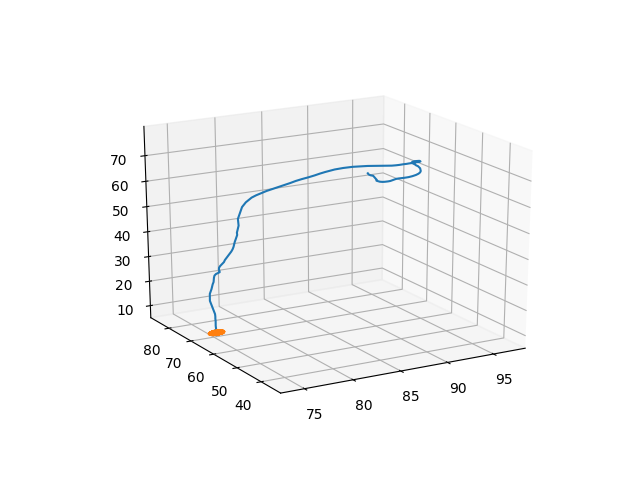

In [29]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])
#print(optimal_steps[:])

In [28]:
states = torch.stack(all_states)
print(states.T[0][:3])

tensor([75.0415, 75.2101, 75.0415], dtype=torch.float64)


In [72]:
print(referenceLine[86])

tensor([ 71.7731, 113.9662,  79.6186])


In [70]:
env.reset()
print(env.state.getCoordinate().numpy(), referenceLine[0])
step = 0
#all_rewards = []
eps_reward = 0
for i in optimal_steps:
    next_state, distance, terminal = env.step(i)
    if distance < 0.71:
        reward = 1 - distance
        #print(reward)
        if reward < 0.3:
            reward = 1
    eps_reward += reward
    #all_rewards.append(reward)
    step += 1
print(eps_reward)

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])
tensor(66.2049, dtype=torch.float64)


In [ ]:
for i in range(n_actions):
    
    next_state, distance, terminal = env.step(i)
    

In [8]:
env.reset()
terminal = False
step = 0
actions = []
past_state = env.state
step = 1
while terminal != True:
    for i in range(n_actions)
    action = np.random.randint(n_actions)
    next_state, reward, terminal = env.step(action)
    if reward < 1:
        actions.append(action)
        past_state = next_state
        print("Action: ", action, "Step: ",step, "Coordinates: ", next_state.getCoordinate().numpy(), referenceLine[step].numpy())
        step += 1
    else:
        env.state = past_state
        env.stepCounter = step
    #action = np.random.choice(possible_actions[step])
    #next_state, reward, terminal = env.step(action)
    #step += 1

print(actions)

Action:  100 Step:  1 Coordinates:  [ 73.651344 107.88106   93.29415 ] [ 74.42344 107.87124  93.08491]
Action:  67 Step:  2 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.16057  107.88882   92.774536]
Action:  100 Step:  3 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.78847 107.96255  92.28433]
Action:  100 Step:  4 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 76.45265  108.118454  91.86654 ]
Action:  100 Step:  5 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.116844 108.27435   91.448746]
Action:  100 Step:  6 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.739716 108.54131   91.02359 ]
Action:  100 Step:  7 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.36259  108.80828   90.598434]
Action:  100 Step:  8 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.996666 109.15176   90.25207 ]
Action:  100 Step:  9 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 79.630745 109.495224  89.9057  ]
Actio

KeyboardInterrupt: 

In [16]:
print(referenceLine[6])
print(referenceLine[7])

tensor([ 77.7397, 108.5413,  91.0236])
tensor([ 78.3626, 108.8083,  90.5984])


In [11]:
state = TractographyState(torch.Tensor([ 77.8994346, 108.7020324, 90.72022516]), env.interpolateDWIatState)
for i in range(n_actions):
    env.state = state
    env.stepCounter -= 1
    next_state, _, terminal = env.step(i)
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.min(torch.sum((referenceLine[7] - qry_pt)**2, dim=1))
    if distance < 0.3:
        print(i, next_state.getCoordinate().numpy(), referenceLine[7].numpy(), distance.numpy())

tensor([ 78.1077, 108.7354,  91.6977], dtype=torch.float64)
tensor([ 77.7615, 108.8643,  91.6973], dtype=torch.float64)
tensor([ 77.8808, 108.4698,  91.6927], dtype=torch.float64)
tensor([ 78.0768, 109.0850,  91.6268], dtype=torch.float64)
tensor([ 77.5148, 108.5987,  91.6375], dtype=torch.float64)
tensor([ 78.3125, 108.4477,  91.5947], dtype=torch.float64)
tensor([ 77.7489, 109.2253,  91.5590], dtype=torch.float64)
tensor([ 77.6419, 108.2420,  91.5700], dtype=torch.float64)
tensor([ 78.4297, 108.8083,  91.5614], dtype=torch.float64)
tensor([ 77.4379, 108.9717,  91.5654], dtype=torch.float64)
tensor([ 78.0813, 108.1849,  91.5566], dtype=torch.float64)
tensor([ 78.1025, 109.3932,  91.4139], dtype=torch.float64)
tensor([ 77.3094, 108.3452,  91.4445], dtype=torch.float64)
tensor([ 78.6147, 108.4838,  91.3841], dtype=torch.float64)
tensor([ 77.4417, 109.2998,  91.3783], dtype=torch.float64)
tensor([ 77.8415, 107.9787,  91.4083], dtype=torch.float64)
tensor([ 78.3907, 109.1557,  91.4638], d

In [9]:
env.reset()
next_state, reward, terminal = env.step(100)
print(next_state.getCoordinate().numpy())
print(reward)
print(terminal)

tensor(187.0214)
[ 73.651344 107.88106   93.29415 ]
-1
True


In [49]:
print(possible_actions)

[[47, 75, 80, 88, 93, 96], [67, 75, 80, 88, 93], [62, 67, 75, 80], [62, 67, 75, 80, 83], [62, 67, 75, 80, 83], [62, 67, 75, 83, 96], [62, 67, 75, 83, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 70, 75, 83, 91, 96], [62, 70, 75, 78, 83, 91], [54, 57, 62, 67, 70, 75, 83], [54, 62, 67, 75], [54, 59, 67, 72], [51, 54, 59, 62, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 56, 59, 64], [51, 56, 59, 64], [51, 56, 59, 64], [50, 51, 53, 56, 59], [50, 51, 53, 56, 61, 66], [53, 58, 61, 66, 74, 79], [58, 66, 71, 74, 79], [58, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79, 84], [58, 63, 71, 79, 84, 92], [58, 63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [38, 71, 79, 84, 92], [38, 63, 71, 84, 92, 97], [38, 71, 84, 92, 97], [38, 84, 92, 97], [38, 76, 84, 92, 97], [38, 76, 

In [8]:
env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
print(env.state.getCoordinate())
print(referenceLine[86])
print(possible_actions[85])
for i in possible_actions[85]:
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    env.stepCounter = 84
    next_state, reward, _ = env.step(z)
    print(next_state.getCoordinate(), reward)

tensor([ 71.5173, 114.6476,  79.9506])
tensor([ 71.7731, 113.9662,  79.6186])
[64, 69, 77, 85, 90, 98]
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)


In [76]:
#env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
for i in range(n_actions):
    env.reset()
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    distance = env.rewardForTerminalState(next_state)
    if distance < 0.3:
        print(referenceLine[86].numpy(), next_state.getCoordinate().numpy(), distance.item())

[ 71.773056 113.966225  79.618576] [ 72.30127204 114.02878755  79.99932066] 0.27901215525974304
[ 71.773056 113.966225  79.618576] [ 71.7609279  113.6971063   80.14330044] 0.2753356828217112
[ 71.773056 113.966225  79.618576] [ 71.37937604 113.65758474  79.97858924] 0.15498393104601757
[ 71.773056 113.966225  79.618576] [ 71.66780472 114.12438903  79.11184227] 0.2567791198339029
[ 71.773056 113.966225  79.618576] [ 71.97880832 114.37794723  79.10548775] 0.26325960220840583
[ 71.773056 113.966225  79.618576] [ 71.31423388 113.95652005  79.25698482] 0.2105177635246191
[ 71.773056 113.966225  79.618576] [ 71.97504289 114.04982978  79.29253904] 0.10630013104166292
[ 71.773056 113.966225  79.618576] [ 71.63016002 113.84417747  79.3660627 ] 0.06376299386222199
[ 71.773056 113.966225  79.618576] [ 72.24376411 114.29266559  79.36222956] 0.2215660937612901
[ 71.773056 113.966225  79.618576] [ 71.91375289 113.81268975  79.56895814] 0.023572970787664616
[ 71.773056 113.966225  79.618576] [ 71.351

In [67]:
distance = env.rewardForTerminalState(next_state)
print(referenceLine[86])
print(distance)

tensor([ 71.7731, 113.9662,  79.6186])
tensor(122.0777, dtype=torch.float64)


In [26]:
for i in range(n_actions):
    env.state = TractographyState(torch.FloatTensor([ 74.64776812, 107.9270337, 93.22325858]), env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    env.stepCounter = 2
    if reward < 0.1:
        reward = 1
    elif reward < 0.5:
        reward = 0
    else:
        reward = -1
    if reward == 1:
        #best_actions.append(i)
        print("[{}]".format(i), referenceLine[2].numpy(), next_state.getCoordinate().numpy(), reward)
#print(best_actions)

In [ ]:
state = TractographyState(torch.FloatTensor(referenceLine[0]), env.interpolateDWIatState)
coordinates = state.getCoordinate()

In [ ]:
print(referenceLine[0])

In [ ]:
print(referenceLine[0])
print(referenceLine[70])

In [ ]:
state = TractographyState(referenceLine[69], env.interpolateDWIatState)

In [ ]:
shape = env.reset().getValue().reshape(-1).shape[0]
print(shape)

In [ ]:
state = torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)

In [ ]:
q_vals = agent.main_dqn(state)

In [ ]:
print(state.getValue().shape)
shape = state.getValue().shape
shape = np.prod(np.array(shape))
print(shape)

In [ ]:
state = TractographyState(referenceLine[70], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance_terminal = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )

#print(distance)
#print(distance_terminal)
reward = (torch.tanh(-distance+5.3) + 2*torch.tanh(-distance_terminal+5.3))/2
print(reward)

print(torch.tanh(-distance+5.3))
print(torch.tanh(-distance_terminal+5.3))

reward += 200/20 * reward.sign()
print(reward)

In [ ]:
print(torch.tanh(-distance_terminal+5.3)+2)

In [ ]:
state = TractographyState([32., 84., 94.], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
print(torch.tanh(-distance+5.3))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(-distance)
print(torch.tanh(-distance)+2)
#print(torch.where(distance < env.maxL2dist_to_terminalState, 1, 0 ))

In [ ]:
print(-1.5 + 5)

In [ ]:
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(round(-distance.item(),4))

In [ ]:
print("Init agent")
#memory = ReplayMemory(size=replay_memory_size)
state = env.reset()
agent = Agent(n_actions=n_actions, inp_size=state.getValue().shape, device=device, hidden=256, agent_history_length=agent_history_length, memory_size=replay_memory_size, learning_rate=learning_rate)

print("Init epsilon-greedy action scheduler")
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=100000, replay_memory_start_size=replay_memory_size, model=agent.main_dqn)

step_counter = 0
    
eps_rewards = []

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0

######## fill memory begins here
    while epoch_step < evaluate_every:  # To Do implement evaluation
        state = env.reset()
        episode_reward_sum = 0
        
        #fill replay memory while interacting with env
        for episode_counter in range(max_episode_length):
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0))
                    
            next_state, reward, terminal = env.step(action)

            if reward >= 1:
                reward = 10
            elif reward > -0.05:
                reward = 1
            
            if episode_counter == max_episode_length-1:
                reward = -100
                terminal = True
            # increase counter
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=state.getValue(),
                                reward=reward,
                                new_state=next_state.getValue(),
                                terminal=terminal)


            state = next_state

        

            ####### optimization is happening here
            if step_counter > replay_memory_size:
                loss = agent.optimize()


            ####### target network update
            if step_counter > replay_memory_size and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if episode ended before maximum step
            if terminal:
                terminal = False
                state = env.reset()
                break
                
        eps_rewards.append(episode_reward_sum)
        
        if len(eps_rewards) % 10 == 0:
            with open(path+'/logs/rewards.dat', 'a') as reward_file:
                print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])) )
    torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))
########## evaluation starting here
    eval_rewards = []
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0), evaluation=True)

            next_state, reward, terminal = env.step(action)

            eval_steps += 1
            eval_episode_reward += reward
            state = next_state

            if terminal:
                terminal = False
                break

        eval_rewards.append(eval_episode_reward)
    
    print("Evaluation score:", np.mean(eval_rewards))

In [ ]:
#!mkdir -p 'checkpoints/'
#torch.save(agent.main_dqn.state_dict(), 'checkpoints/fiber_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(rewards[-100:])))